In [1]:
import pandas as pd
import json
import torch
import sys
import os
from pathlib import Path
from datetime import datetime
from datasets import Dataset

root_path = os.path.abspath("..")
sys.path.append(root_path)

from src.hs_peft import (
    ExperimentConfig,
    DataManager,
    HateSpeechTrainer,
    ModelEvaluator
)
from src.zero_few_shot import (
    ZeroFewShotConfig,
    ZeroFewShotClassifier
)


In [ ]:
os.chdir("..")

# Diretórios
DATA_DIR = "./data/cross_dataset"
OUTPUT_DIR = "./results/cross_dataset"
CACHE_DIR = "./cache"

# Criar diretório de resultados
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Parâmetros compartilhados (IGUAIS para todos)
SEED = 42
MAX_LENGTH = 256
LABEL_NAMES = ["0", "1"]

# Modelos
SLM_MODEL = "FacebookAI/xlm-roberta-base" #multi
SLM_MODEL_BR = "neuralmind/bert-base-portuguese-cased"  # BERTimbau
LLM_MODEL = "meta-llama/Llama-3.2-3B" #multi
LLM_MODEL_BR = "22h/open-cabrita3b"
LLM_MODEL_INSTRUCT = "meta-llama/Llama-3.2-3B-Instruct" 

all_results = {}

## Experimento 1a - Fine tuning SLMs (BERTimbau)

In [3]:
print(f"\n{'='*70}")
print("MÉTODO 1: SLM FINE-TUNING (BERTimbau)")
print(f"{'='*70}\n")

config_slm = ExperimentConfig(
    # Paths
    data_path=DATA_DIR,
    output_path=f"{OUTPUT_DIR}/slm_finetuning_bertimbau",
    cache_dir=CACHE_DIR,
    
    # Reprodutibilidade ⭐
    seed=SEED,
    
    # Dados ⭐
    max_length=MAX_LENGTH,
    
    # Training - SLM específico
    batch_size=16,          # Maior batch (SLM cabe bem na memória)
    num_epochs=5,           # SLMs precisam mais épocas
    learning_rate=2e-5,     # Learning rate padrão BERT
    weight_decay=0.01,
    warmup_ratio=0.1,
    gradient_accumulation_steps=1,
    early_stopping_patience=3,
    
    # Sem quantização (SLM não precisa)
    use_4bit=False,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_quant_type="nf4",
    use_nested_quant=False,
    
    # LoRA (não usado aqui)
    lora_r=16,
    lora_alpha=16,
    lora_dropout=0.05,
    lora_bias="none",
    lora_target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    
    # Prompt Tuning (não usado aqui)
    num_virtual_tokens=20,
    prompt_tuning_init="TEXT",
    
    # Otimizações
    gradient_checkpointing=False,
    optim="adamw_torch",
    max_grad_norm=1.0,
    
    # Labels
    label_names=LABEL_NAMES
)


MÉTODO 1: SLM FINE-TUNING (BERTimbau)



In [4]:
# Carregar dados
data_manager_slm = DataManager(config_slm)
dataset_slm = data_manager_slm.load_data(
    train_path=f"{DATA_DIR}/train.csv",
    val_path=f"{DATA_DIR}/val.csv",
    test_path=f"{DATA_DIR}/test.csv"
)

# Calcular class weights
class_weights_slm = data_manager_slm.compute_class_weights(dataset_slm['train'])

Dados carregados:
  Train: 4200 exemplos
  Val: 1050 exemplos
  Test: 1738 exemplos

Após remoção de duplicatas:
  Train: 4200 exemplos
  Val: 1050 exemplos

DISTRIBUIÇÃO DE CLASSES (Training Set)
0 (0): 2117 (50.40%)
1 (1): 2083 (49.60%)

Pesos calculados para balanceamento:
0: 0.9920
1: 1.0082



In [5]:
# Treinar
trainer_slm = HateSpeechTrainer(config_slm)
trainer_obj_slm, model_slm, tokenizer_slm = trainer_slm.train_slm(
    model_name=SLM_MODEL_BR,
    dataset=dataset_slm,
    output_dir=f"{OUTPUT_DIR}/slm_finetuning_bertimbau",
    class_weights=class_weights_slm
)


[SLM] Carregando modelo: neuralmind/bert-base-portuguese-cased


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lucas\Desktop\mestrado\dl\projeto\dl_hs_peft\cache\models--neuralmind--bert-base-portuguese-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1050 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Map:   0%|          | 0/1738 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

c:\Users\lucas\Desktop\mestrado\dl\projeto\dl_hs_peft\src\hs_peft.py:433: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(



Iniciando treinamento SLM: neuralmind/bert-base-portuguese-cased



Epoch,Training Loss,Validation Loss,F1,Accuracy,F1 Class 0,F1 Class 1
1,0.288700,0.285758,0.885731,0.886667,0.896070,0.875393
2,0.183700,0.332426,0.909505,0.909524,0.910798,0.908213
3,0.093300,0.401132,0.910393,0.910476,0.913124,0.907662
4,0.051200,0.459899,0.908555,0.908571,0.909774,0.907336
5,0.018000,0.473564,0.908545,0.908571,0.910112,0.906977


In [6]:
# Avaliar
evaluator_slm = ModelEvaluator(config_slm)
results_slm = evaluator_slm.evaluate_model(
    model_slm, tokenizer_slm, 
    dataset_slm['test'],
    output_dir=f"{OUTPUT_DIR}/slm_finetuning_bertimbau",
    model_name="slm_finetuning_bertimbau"
)

all_results['slm_finetuning_bertimbau'] = results_slm

print(f"\n✅ SLM Fine-Tuning F1: {results_slm['macro_f1']:.4f}")


Avaliando modelo: slm_finetuning_bertimbau

Gerando predições...
Calculando métricas...

RESULTADOS
Macro-F1: 0.6301
Accuracy: 0.8049
Macro Avg Precision: 0.6220
ROC-AUC: 0.7212
Expected Calibration Error: 0.1750

MÉTRICAS POR CLASSE

0:
  F1: 0.3757
  Precision: 0.3529
  Recall: 0.4016
  Avg Precision (AP): 0.3125

1:
  F1: 0.8844
  Precision: 0.8951
  Recall: 0.8740
  Avg Precision (AP): 0.9315


Gerando visualizações...
✓ Visualizações salvas em results\cross_dataset\slm_finetuning_bertimbau
✓ Resultados detalhados salvos em results\cross_dataset\slm_finetuning_bertimbau\slm_finetuning_bertimbau_detailed_results.json

✅ SLM Fine-Tuning F1: 0.6301


In [7]:
# Liberar memória
del model_slm, tokenizer_slm, trainer_obj_slm
import torch
torch.cuda.empty_cache()

## Experimento 1b - SLM finetuning XLM-R

In [3]:
print(f"\n{'='*70}")
print("MÉTODO 1: SLM FINE-TUNING (XLM-R)")
print(f"{'='*70}\n")

config_slm = ExperimentConfig(
    # Paths
    data_path=DATA_DIR,
    output_path=f"{OUTPUT_DIR}/slm_finetuning_xlmr",
    cache_dir=CACHE_DIR,
    
    # Reprodutibilidade ⭐
    seed=SEED,
    
    # Dados ⭐
    max_length=MAX_LENGTH,
    
    # Training - SLM específico ⚠️
    batch_size=16,          # Maior batch (SLM cabe bem na memória)
    num_epochs=5,           # SLMs precisam mais épocas
    learning_rate=2e-5,     # Learning rate padrão BERT
    weight_decay=0.01,
    warmup_ratio=0.1,
    gradient_accumulation_steps=1,
    early_stopping_patience=3,
    
    # Sem quantização (SLM não precisa)
    use_4bit=False,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_quant_type="nf4",
    use_nested_quant=False,
    
    # LoRA (não usado aqui)
    lora_r=16,
    lora_alpha=16,
    lora_dropout=0.05,
    lora_bias="none",
    lora_target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    
    # Prompt Tuning (não usado aqui)
    num_virtual_tokens=20,
    prompt_tuning_init="TEXT",
    
    # Otimizações
    gradient_checkpointing=False,
    optim="adamw_torch",
    max_grad_norm=1.0,
    
    # Labels
    label_names=LABEL_NAMES
)


MÉTODO 1: SLM FINE-TUNING (XLM-R)



In [4]:
# Carregar dados
data_manager_slm = DataManager(config_slm)
dataset_slm = data_manager_slm.load_data(
    train_path=f"{DATA_DIR}/train.csv",
    val_path=f"{DATA_DIR}/val.csv",
    test_path=f"{DATA_DIR}/test.csv"
)

# Calcular class weights
class_weights_slm = data_manager_slm.compute_class_weights(dataset_slm['train'])

Dados carregados:
  Train: 4200 exemplos
  Val: 1050 exemplos
  Test: 1738 exemplos

Após remoção de duplicatas:
  Train: 4200 exemplos
  Val: 1050 exemplos

DISTRIBUIÇÃO DE CLASSES (Training Set)
0 (0): 2117 (50.40%)
1 (1): 2083 (49.60%)

Pesos calculados para balanceamento:
0: 0.9920
1: 1.0082



In [5]:
# Treinar
trainer_slm = HateSpeechTrainer(config_slm)
trainer_obj_slm, model_slm, tokenizer_slm = trainer_slm.train_slm(
    model_name=SLM_MODEL,
    dataset=dataset_slm,
    output_dir=f"{OUTPUT_DIR}/slm_finetuning_xlmr",
    class_weights=class_weights_slm
)


[SLM] Carregando modelo: FacebookAI/xlm-roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lucas\Desktop\mestrado\dl\projeto\dl_hs_peft\cache\models--FacebookAI--xlm-roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1050 [00:00<?, ? examples/s]

Map:   0%|          | 0/1738 [00:00<?, ? examples/s]

c:\Users\lucas\Desktop\mestrado\dl\projeto\dl_hs_peft\src\hs_peft.py:433: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(



Iniciando treinamento SLM: FacebookAI/xlm-roberta-base



Epoch,Training Loss,Validation Loss,F1,Accuracy,F1 Class 0,F1 Class 1
1,0.453500,0.361383,0.869461,0.869524,0.872321,0.866602
2,0.283300,0.286508,0.884686,0.884762,0.887651,0.881720
3,0.190500,0.455680,0.884550,0.884762,0.889498,0.879602
4,0.152300,0.507066,0.884468,0.884762,0.890299,0.878636
5,0.085900,0.566501,0.893221,0.893333,0.896679,0.889764


In [6]:
# Avaliar
evaluator_slm = ModelEvaluator(config_slm)
results_slm = evaluator_slm.evaluate_model(
    model_slm, tokenizer_slm, 
    dataset_slm['test'],
    output_dir=f"{OUTPUT_DIR}/slm_finetuning_xlmr",
    model_name="slm_finetuning_xlmr"
)

all_results['slm_finetuning_xlmr'] = results_slm

print(f"\n✅ SLM Fine-Tuning F1: {results_slm['macro_f1']:.4f}")


Avaliando modelo: slm_finetuning_xlmr

Gerando predições...
Calculando métricas...

RESULTADOS
Macro-F1: 0.6039
Accuracy: 0.7871
Macro Avg Precision: 0.6007
ROC-AUC: 0.6989
Expected Calibration Error: 0.1975

MÉTRICAS POR CLASSE

0:
  F1: 0.3345
  Precision: 0.3079
  Recall: 0.3661
  Avg Precision (AP): 0.2778

1:
  F1: 0.8733
  Precision: 0.8879
  Recall: 0.8592
  Avg Precision (AP): 0.9237


Gerando visualizações...
✓ Visualizações salvas em results\cross_dataset\slm_finetuning_xlmr
✓ Resultados detalhados salvos em results\cross_dataset\slm_finetuning_xlmr\slm_finetuning_xlmr_detailed_results.json

✅ SLM Fine-Tuning F1: 0.6039


## Experimento 2a - PEFT LoRA Llama

In [3]:
print(f"\n{'='*70}")
print("MÉTODO 2: LLM + LoRA (Llama 3.2 3B)")
print(f"{'='*70}\n")

config_lora = ExperimentConfig(
    # Paths
    data_path=DATA_DIR,
    output_path=f"{OUTPUT_DIR}/llm_lora_llama",
    cache_dir=CACHE_DIR,
    
    # Reprodutibilidade ⭐
    seed=SEED,
    
    # Dados ⭐
    max_length=MAX_LENGTH,
    
    # Training - LoRA específico ⚠️
    batch_size=4,           # Menor que SLM (LLM usa mais memória)
    num_epochs=3,           # LoRA converge rápido
    learning_rate=1e-4,     # Maior que fine-tuning completo
    weight_decay=0.0001,#0.01,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,  # Compensa batch menor
    early_stopping_patience=3,
    
    # Quantização obrigatória
    use_4bit=True,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_quant_type="nf4",
    use_nested_quant=True,
    
    # LoRA - CRÍTICO ⚠️⚠️⚠️
    lora_r=8,              # Rank da matriz (hiperparâmetro principal)
    lora_alpha=8,          # Scaling (geralmente = r)
    lora_dropout=0.05,
    lora_bias="none",
    lora_target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    
    # Prompt Tuning (não usado)
    num_virtual_tokens=20,
    prompt_tuning_init="TEXT",
    
    # Otimizações
    gradient_checkpointing=True,
    #optim="paged_adamw_8bit",
    optim="adamw_torch",
    max_grad_norm=0.3,
    
    label_names=LABEL_NAMES
)


MÉTODO 2: LLM + LoRA (Llama 3.2 3B)



In [4]:
# Carregar dados
data_manager_lora = DataManager(config_lora)
dataset_lora = data_manager_lora.load_data(
    train_path=f"{DATA_DIR}/train.csv",
    val_path=f"{DATA_DIR}/val.csv",
    test_path=f"{DATA_DIR}/test.csv"
)

class_weights_lora = data_manager_lora.compute_class_weights(dataset_lora['train'])

Dados carregados:
  Train: 4200 exemplos
  Val: 1050 exemplos
  Test: 1738 exemplos

Após remoção de duplicatas:
  Train: 4200 exemplos
  Val: 1050 exemplos

DISTRIBUIÇÃO DE CLASSES (Training Set)
0 (0): 2117 (50.40%)
1 (1): 2083 (49.60%)

Pesos calculados para balanceamento:
0: 0.9920
1: 1.0082



In [5]:
# Treinar
trainer_lora = HateSpeechTrainer(config_lora)
trainer_obj_lora, model_lora, tokenizer_lora = trainer_lora.train_llm_lora(
    model_name=LLM_MODEL,
    dataset=dataset_lora,
    output_dir=f"{OUTPUT_DIR}/llm_lora_llama",
    class_weights=class_weights_lora
)



[LLM-LoRA] Carregando modelo: meta-llama/Llama-3.2-3B


`torch_dtype` is deprecated! Use `dtype` instead!
Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc6 in position 8: invalid continuation byte


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-3B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 4,593,664 || all params: 3,217,349,632 || trainable%: 0.1428


Map:   0%|          | 0/4200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1050 [00:00<?, ? examples/s]

Map:   0%|          | 0/1738 [00:00<?, ? examples/s]

c:\Users\lucas\Desktop\mestrado\dl\projeto\dl_hs_peft\src\hs_peft.py:509: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(



Iniciando treinamento LLM-LoRA: meta-llama/Llama-3.2-3B



Epoch,Training Loss,Validation Loss,F1,Accuracy,F1 Class 0,F1 Class 1
1,0.449300,0.286377,0.909372,0.909524,0.913083,0.905660
2,0.473300,0.369629,0.905609,0.905714,0.908756,0.902463
3,0.099200,0.414307,0.909472,0.909524,0.911628,0.907317


In [6]:
# Avaliar
evaluator_lora = ModelEvaluator(config_lora)
results_lora = evaluator_lora.evaluate_model(
    model_lora, tokenizer_lora,
    dataset_lora['test'],
    output_dir=f"{OUTPUT_DIR}/llm_lora_llama",
    model_name="lora_llama"
)

all_results['llm_lora_llama'] = results_lora

print(f"\n✅ LLM LoRA F1: {results_lora['macro_f1']:.4f}")


Avaliando modelo: lora_llama

Gerando predições...
Calculando métricas...

RESULTADOS
Macro-F1: 0.6371
Accuracy: 0.8113
Macro Avg Precision: 0.6167
ROC-AUC: 0.7117
Expected Calibration Error: 0.1581

MÉTRICAS POR CLASSE

0:
  F1: 0.3858
  Precision: 0.3679
  Recall: 0.4055
  Avg Precision (AP): 0.3149

1:
  F1: 0.8885
  Precision: 0.8964
  Recall: 0.8807
  Avg Precision (AP): 0.9185


Gerando visualizações...
✓ Visualizações salvas em results\cross_dataset\llm_lora_llama
✓ Resultados detalhados salvos em results\cross_dataset\llm_lora_llama\lora_llama_detailed_results.json

✅ LLM LoRA F1: 0.6371


In [7]:
# Liberar memória
del model_lora, tokenizer_lora, trainer_obj_lora
torch.cuda.empty_cache()

## Experimento 2b - PEFT LoRA Cabrita

In [3]:
print(f"\n{'='*70}")
print("MÉTODO 2: LLM + LoRA (Cabrita 3B)")
print(f"{'='*70}\n")

config_lora = ExperimentConfig(
    # Paths
    data_path=DATA_DIR,
    output_path=f"{OUTPUT_DIR}/llm_lora_cabrita",
    cache_dir=CACHE_DIR,
    
    # Reprodutibilidade ⭐
    seed=SEED,
    
    # Dados ⭐
    max_length=MAX_LENGTH,
    
    # Training - LoRA específico ⚠️
    batch_size=4,           # Menor que SLM (LLM usa mais memória)
    num_epochs=3,           # LoRA converge rápido
    learning_rate=1e-4,     # Maior que fine-tuning completo
    weight_decay=0.0001,#0.01,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,  # Compensa batch menor
    early_stopping_patience=3,
    
    # Quantização obrigatória
    use_4bit=True,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_quant_type="nf4",
    use_nested_quant=True,
    
    # LoRA - CRÍTICO ⚠️⚠️⚠️
    lora_r=8,              # Rank da matriz (hiperparâmetro principal)
    lora_alpha=8,          # Scaling (geralmente = r)
    lora_dropout=0.05,
    lora_bias="none",
    lora_target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    
    # Prompt Tuning (não usado)
    num_virtual_tokens=20,
    prompt_tuning_init="TEXT",
    
    # Otimizações
    gradient_checkpointing=True,
    #optim="paged_adamw_8bit",
    optim="adamw_torch",
    max_grad_norm=0.3,
    
    label_names=LABEL_NAMES
)


MÉTODO 2: LLM + LoRA (Cabrita 3B)



In [4]:
# Carregar dados
data_manager_lora = DataManager(config_lora)
dataset_lora = data_manager_lora.load_data(
    train_path=f"{DATA_DIR}/train.csv",
    val_path=f"{DATA_DIR}/val.csv",
    test_path=f"{DATA_DIR}/test.csv"
)

class_weights_lora = data_manager_lora.compute_class_weights(dataset_lora['train'])

Dados carregados:
  Train: 4200 exemplos
  Val: 1050 exemplos
  Test: 1738 exemplos

Após remoção de duplicatas:
  Train: 4200 exemplos
  Val: 1050 exemplos

DISTRIBUIÇÃO DE CLASSES (Training Set)
0 (0): 2117 (50.40%)
1 (1): 2083 (49.60%)

Pesos calculados para balanceamento:
0: 0.9920
1: 1.0082



In [5]:
# Treinar
trainer_lora = HateSpeechTrainer(config_lora)
trainer_obj_lora, model_lora, tokenizer_lora = trainer_lora.train_llm_lora(
    model_name=LLM_MODEL_BR,
    dataset=dataset_lora,
    output_dir=f"{OUTPUT_DIR}/llm_lora_cabrita",
    class_weights=class_weights_lora
)



[LLM-LoRA] Carregando modelo: 22h/open-cabrita3b


tokenizer_config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lucas\Desktop\mestrado\dl\projeto\dl_hs_peft\cache\models--22h--open-cabrita3b. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Fa

tokenizer.model:   0%|          | 0.00/889k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc6 in position 8: invalid continuation byte


pytorch_model.bin.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at 22h/open-cabrita3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 5,331,200 || all params: 3,393,411,200 || trainable%: 0.1571


Map:   0%|          | 0/4200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1050 [00:00<?, ? examples/s]

Map:   0%|          | 0/1738 [00:00<?, ? examples/s]

c:\Users\lucas\Desktop\mestrado\dl\projeto\dl_hs_peft\src\hs_peft.py:509: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(



Iniciando treinamento LLM-LoRA: 22h/open-cabrita3b



Epoch,Training Loss,Validation Loss,F1,Accuracy,F1 Class 0,F1 Class 1
1,0.480200,0.262451,0.914951,0.915238,0.919892,0.910010
2,0.224100,0.308105,0.921841,0.921905,0.924074,0.919608
3,0.078100,0.358643,0.922837,0.922857,0.924086,0.921588


In [6]:
# Avaliar
evaluator_lora = ModelEvaluator(config_lora)
results_lora = evaluator_lora.evaluate_model(
    model_lora, tokenizer_lora,
    dataset_lora['test'],
    output_dir=f"{OUTPUT_DIR}/llm_lora_cabrita",
    model_name="lora_cabrita"
)

all_results['llm_lora_cabrita'] = results_lora

print(f"\n✅ LLM LoRA F1: {results_lora['macro_f1']:.4f}")


Avaliando modelo: lora_cabrita

Gerando predições...
Calculando métricas...

RESULTADOS
Macro-F1: 0.6233
Accuracy: 0.8101
Macro Avg Precision: 0.6251
ROC-AUC: 0.7141
Expected Calibration Error: 0.1562

MÉTRICAS POR CLASSE

0:
  F1: 0.3580
  Precision: 0.3538
  Recall: 0.3622
  Avg Precision (AP): 0.3308

1:
  F1: 0.8886
  Precision: 0.8904
  Recall: 0.8868
  Avg Precision (AP): 0.9194


Gerando visualizações...
✓ Visualizações salvas em results\cross_dataset\llm_lora_cabrita
✓ Resultados detalhados salvos em results\cross_dataset\llm_lora_cabrita\lora_cabrita_detailed_results.json

✅ LLM LoRA F1: 0.6233


In [7]:
# Liberar memória
import torch
del model_lora, tokenizer_lora, trainer_obj_lora
torch.cuda.empty_cache()

## Experimento 3a - PEFT Prompt tuning Llama

In [3]:
print(f"\n{'='*70}")
print("MÉTODO 3: LLM + PROMPT TUNING (Llama 3.2 1B)")
print(f"{'='*70}\n")

config_prompt = ExperimentConfig(
    # Paths
    data_path=DATA_DIR,
    output_path=f"{OUTPUT_DIR}/llm_prompt_llama",
    cache_dir=CACHE_DIR,
    
    # Reprodutibilidade ⭐
    seed=SEED,
    
    # Dados ⭐
    max_length=MAX_LENGTH,
    
    # Training - Prompt Tuning específico ⚠️
    batch_size=8,
    num_epochs=10,           # Pode precisar mais que LoRA
    learning_rate=3e-2,#1e-2,     # MUITO maior! (crítico)
    weight_decay=0.0,       # Geralmente sem weight decay
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    early_stopping_patience=5,
    
    # Quantização
    use_4bit=True,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_quant_type="nf4",
    use_nested_quant=True,
    
    # LoRA (não usado)
    lora_r=16,
    lora_alpha=16,
    lora_dropout=0.05,
    lora_bias="none",
    lora_target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    
    # Prompt Tuning - CRÍTICO ⚠️⚠️⚠️
    num_virtual_tokens=40,  # Número de soft tokens (hiperparâmetro principal)
    prompt_tuning_init="TEXT",  # TEXT geralmente melhor
    
    # Otimizações
    gradient_checkpointing=True,
    optim="adamw_torch",
    max_grad_norm=0.3,
    
    label_names=LABEL_NAMES
)


MÉTODO 3: LLM + PROMPT TUNING (Llama 3.2 1B)



In [4]:
# Carregar dados
data_manager_prompt = DataManager(config_prompt)
dataset_prompt = data_manager_prompt.load_data(
    train_path=f"{DATA_DIR}/train.csv",
    val_path=f"{DATA_DIR}/val.csv",
    test_path=f"{DATA_DIR}/test.csv"
)

class_weights_prompt = data_manager_prompt.compute_class_weights(dataset_prompt['train'])

Dados carregados:
  Train: 4200 exemplos
  Val: 1050 exemplos
  Test: 1738 exemplos

Após remoção de duplicatas:
  Train: 4200 exemplos
  Val: 1050 exemplos

DISTRIBUIÇÃO DE CLASSES (Training Set)
0 (0): 2117 (50.40%)
1 (1): 2083 (49.60%)

Pesos calculados para balanceamento:
0: 0.9920
1: 1.0082



In [5]:
# todando de novo pra finalizar (deixei a celula abaixo pra nao perder os resultados)
# Treinar
trainer_prompt = HateSpeechTrainer(config_prompt)
trainer_obj_prompt, model_prompt, tokenizer_prompt = trainer_prompt.train_llm_prompt_tuning(
    model_name=LLM_MODEL,
    dataset=dataset_prompt,
    output_dir=f"{OUTPUT_DIR}/llm_prompt_llama",
    prompt_text=None,  # Usa prompt padrão
    class_weights=class_weights_prompt
)



[LLM-Prompt Tuning] Carregando modelo: meta-llama/Llama-3.2-3B


`torch_dtype` is deprecated! Use `dtype` instead!
Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc6 in position 8: invalid continuation byte


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Avaliar
evaluator_prompt = ModelEvaluator(config_prompt)
results_prompt = evaluator_prompt.evaluate_model(
    model_prompt, tokenizer_prompt,
    dataset_prompt['test'],
    output_dir=f"{OUTPUT_DIR}/llm_prompt_llama",
    model_name="llama_prompt"
)

all_results['llm_prompt_tuning'] = results_prompt

print(f"\n✅ LLM Prompt Tuning F1: {results_prompt['macro_f1']:.4f}")


Avaliando modelo: llama_prompt

Gerando predições...
Calculando métricas...

RESULTADOS
Macro-F1: 0.5517
Accuracy: 0.7675
Macro Avg Precision: 0.5406
ROC-AUC: 0.5962
Expected Calibration Error: 0.0717

MÉTRICAS POR CLASSE

0:
  F1: 0.2406
  Precision: 0.2302
  Recall: 0.2520
  Avg Precision (AP): 0.1994

1:
  F1: 0.8628
  Precision: 0.8699
  Recall: 0.8558
  Avg Precision (AP): 0.8817


Gerando visualizações...
✓ Visualizações salvas em results\cross_dataset\llm_prompt_llama
✓ Resultados detalhados salvos em results\cross_dataset\llm_prompt_llama\llama_prompt_detailed_results.json

✅ LLM Prompt Tuning F1: 0.5517


In [ ]:
# Liberar memória
del model_prompt, tokenizer_prompt, trainer_obj_prompt
torch.cuda.empty_cache()

## Experimento 3b - Prompt tuning BR Cabrita

In [3]:
print(f"\n{'='*70}")
print("MÉTODO 3: LLM + PROMPT TUNING (Cabrita 3b)")
print(f"{'='*70}\n")

config_prompt = ExperimentConfig(
    # Paths
    data_path=DATA_DIR,
    output_path=f"{OUTPUT_DIR}/llm_prompt_cabrita",
    cache_dir=CACHE_DIR,
    
    # Reprodutibilidade ⭐
    seed=SEED,
    
    # Dados ⭐
    max_length=MAX_LENGTH,
    
    # Training - Prompt Tuning específico ⚠️
    batch_size=4,
    num_epochs=10,           # Pode precisar mais que LoRA
    learning_rate=3e-2,#1e-2,     # MUITO maior! (crítico)
    weight_decay=0.0,       # Geralmente sem weight decay
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    early_stopping_patience=5,
    
    # Quantização
    use_4bit=True,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_quant_type="nf4",
    use_nested_quant=True,
    
    # LoRA (não usado)
    lora_r=16,
    lora_alpha=16,
    lora_dropout=0.05,
    lora_bias="none",
    lora_target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    
    # Prompt Tuning - CRÍTICO ⚠️⚠️⚠️
    num_virtual_tokens=40,  # Número de soft tokens (hiperparâmetro principal)
    prompt_tuning_init="TEXT",  # TEXT geralmente melhor
    
    # Otimizações
    gradient_checkpointing=True,
    optim="adamw_torch",
    max_grad_norm=0.3,
    
    label_names=LABEL_NAMES
)


MÉTODO 3: LLM + PROMPT TUNING (Cabrita 3b)



In [4]:
# Carregar dados
data_manager_prompt = DataManager(config_prompt)
dataset_prompt = data_manager_prompt.load_data(
    train_path=f"{DATA_DIR}/train.csv",
    val_path=f"{DATA_DIR}/val.csv",
    test_path=f"{DATA_DIR}/test.csv"
)

class_weights_prompt = data_manager_prompt.compute_class_weights(dataset_prompt['train'])

Dados carregados:
  Train: 4200 exemplos
  Val: 1050 exemplos
  Test: 1738 exemplos

Após remoção de duplicatas:
  Train: 4200 exemplos
  Val: 1050 exemplos

DISTRIBUIÇÃO DE CLASSES (Training Set)
0 (0): 2117 (50.40%)
1 (1): 2083 (49.60%)

Pesos calculados para balanceamento:
0: 0.9920
1: 1.0082



In [5]:
#OBS: tive que alterar para bfloat16 na hora de carregar o modelo (torch_dtype=torch.bfloat16 if self.config.use_4bit else torch.float32)
# Treinar
trainer_prompt = HateSpeechTrainer(config_prompt)
trainer_obj_prompt, model_prompt, tokenizer_prompt = trainer_prompt.train_llm_prompt_tuning(
    model_name=LLM_MODEL_BR,
    dataset=dataset_prompt,
    output_dir=f"{OUTPUT_DIR}/llm_prompt_cabrita",
    prompt_text=None,  # Usa prompt padrão
    class_weights=class_weights_prompt
)



[LLM-Prompt Tuning] Carregando modelo: 22h/open-cabrita3b


`torch_dtype` is deprecated! Use `dtype` instead!
Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc6 in position 8: invalid continuation byte


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at 22h/open-cabrita3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 134,400 || all params: 3,388,214,400 || trainable%: 0.0040


Map:   0%|          | 0/4200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1050 [00:00<?, ? examples/s]

Map:   0%|          | 0/1738 [00:00<?, ? examples/s]

c:\Users\lucas\Desktop\mestrado\dl\projeto\dl_hs_peft\src\hs_peft.py:586: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(



Iniciando treinamento LLM-Prompt Tuning: 22h/open-cabrita3b



LlamaForSequenceClassification will not detect padding tokens in `inputs_embeds`. Results may be unexpected if using padding tokens in conjunction with `inputs_embeds.`


Epoch,Training Loss,Validation Loss,F1,Accuracy,F1 Class 0,F1 Class 1
1,12.574700,2.496103,0.775002,0.775238,0.767717,0.782288
2,10.971600,3.478239,0.862849,0.864762,0.879046,0.846652
3,3.555200,5.035832,0.797362,0.806667,0.840784,0.753939
4,1.797700,1.117267,0.853855,0.854286,0.845921,0.861789
5,1.235900,2.640161,0.787970,0.793333,0.754247,0.821693
6,1.364700,1.036407,0.899371,0.900000,0.907326,0.891417
7,0.303000,1.153143,0.904088,0.904762,0.912127,0.896050
8,0.323700,0.914416,0.911293,0.911429,0.914757,0.907830
9,0.111700,0.926328,0.917143,0.917143,0.917064,0.917222
10,0.042000,0.875223,0.918052,0.918095,0.919926,0.916179


In [6]:
# Avaliar
evaluator_prompt = ModelEvaluator(config_prompt)
results_prompt = evaluator_prompt.evaluate_model(
    model_prompt, tokenizer_prompt,
    dataset_prompt['test'],
    output_dir=f"{OUTPUT_DIR}/llm_prompt_cabrita",
    model_name="cabrita_prompt"
)

all_results['llm_prompt_tuning'] = results_prompt

print(f"\n✅ LLM Prompt Tuning F1: {results_prompt['macro_f1']:.4f}")


Avaliando modelo: cabrita_prompt

Gerando predições...
Calculando métricas...

RESULTADOS
Macro-F1: 0.5917
Accuracy: 0.7739
Macro Avg Precision: 0.5795
ROC-AUC: 0.6359
Expected Calibration Error: 0.2138

MÉTRICAS POR CLASSE

0:
  F1: 0.3189
  Precision: 0.2848
  Recall: 0.3622
  Avg Precision (AP): 0.2660

1:
  F1: 0.8644
  Precision: 0.8855
  Recall: 0.8443
  Avg Precision (AP): 0.8931


Gerando visualizações...
✓ Visualizações salvas em results\cross_dataset\llm_prompt_cabrita
✓ Resultados detalhados salvos em results\cross_dataset\llm_prompt_cabrita\cabrita_prompt_detailed_results.json

✅ LLM Prompt Tuning F1: 0.5917


In [7]:
# Liberar memória
import torch
del model_prompt, tokenizer_prompt, trainer_obj_prompt
torch.cuda.empty_cache()

## Experimento 4a - few-shot classification (llama)

In [3]:
print(f"\n{'='*70}")
print("MÉTODO 4: ZERO-SHOT CLASSIFICATION (Llama 3.2 3B)")
print(f"{'='*70}\n")

config_zero = ZeroFewShotConfig(
    model_name=LLM_MODEL,
    cache_dir=CACHE_DIR,
    
    # Reprodutibilidade ⭐
    seed=SEED,
    
    # Quantização (mesmo dos outros)
    use_4bit=True,
    
    # Zero-shot
    num_shots=0,
    
    # Geração ⚠️
    max_new_tokens=50,
    temperature=0.1,        # Baixa para determinismo
    do_sample=False,        # Greedy
    
    # Processamento
    batch_size=8,           # Mesmo dos LLMs
    max_length=MAX_LENGTH,  # ⭐ Mesmo
)


prompt_zero = """Tarefa: Classificar se o texto contém discurso de ódio.

Discurso de ódio: ataque baseado em raça, religião, gênero, orientação sexual, etc.

Exemplo 1:
Texto: "Ótima pergunta, gostei bastante!"
Classe: 0

Exemplo 2:
Texto: "COMUNISTA SAFADA, MALPARIDA, DESGRAÇADA!!"
Classe: 1

Exemplo 3:
Texto: "bando de marginais pretos"
Classe: 1

Exemplo 4:
Texto: Não concordo com essa política do governo
Classe: 0

Agora classifique:
Texto: "{text}"
Classe:"""


MÉTODO 4: ZERO-SHOT CLASSIFICATION (Llama 3.2 3B)



In [4]:
# LLAMA NORMAL
# Carregar apenas test
test_df = pd.read_csv(f"{DATA_DIR}/test.csv")
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

# Criar classificador
classifier_zero = ZeroFewShotClassifier(config_zero, LABEL_NAMES)

# Avaliar
results_zero = classifier_zero.evaluate(
    test_dataset=test_dataset,
    prompt_template=prompt_zero,
    verbose=True,
    save_plots=True,
    output_dir=f"{OUTPUT_DIR}/llm_fewshot_llama"
)

all_results['zero_shot'] = results_zero

print(f"\n✅ Zero-Shot F1: {results_zero['macro_f1']:.4f}")

`torch_dtype` is deprecated! Use `dtype` instead!
Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc6 in position 8: invalid continuation byte


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lucas\Desktop\mestrado\dl\projeto\dl_hs_peft\cache\models--meta-llama--Llama-3.2-3B. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
The following generation flags are not valid and may be ignored: ['temperature


Modelo carregado: meta-llama/Llama-3.2-3B
Modo: Zero-Shot
Classes: ['0', '1']

Processando 1738 exemplos...
Não foi possível extrair label de: 'as armas que podem, para matar os homossexuais, mas nunca foram presos por terem matado um homem que se apaixonou por um homem. São os mesmos que dizem que os homossexuais são' - usando 0
Processados 80/1738 exemplos
Não foi possível extrair label de: 'ia USER e liberdade USER e igualdade USER e direitos USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER' - usando 0
Não foi possível extrair label de: '! E USER vai falar USER que USER é gay? USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER' - usando 0
Processados 160/1738 exemplos
Não foi possível extrair label de: 'que o USER vai tra

In [5]:
# Liberar memória
del classifier_zero
torch.cuda.empty_cache()

## Experimento 4b - few-shot cabrita

In [6]:
print(f"\n{'='*70}")
print("MÉTODO 4: ZERO-SHOT CLASSIFICATION (cabrita)")
print(f"{'='*70}\n")

config_zero = ZeroFewShotConfig(
    model_name=LLM_MODEL_BR,
    cache_dir=CACHE_DIR,
    
    # Reprodutibilidade ⭐
    seed=SEED,
    
    # Quantização (mesmo dos outros)
    use_4bit=True,
    
    # Zero-shot
    num_shots=0,
    
    # Geração ⚠️
    max_new_tokens=50,
    temperature=0.1,        # Baixa para determinismo
    do_sample=False,        # Greedy
    
    # Processamento
    batch_size=8,           # Mesmo dos LLMs
    max_length=MAX_LENGTH,  # ⭐ Mesmo
)

# Prompt customizado (⚠️ CRÍTICO - teste múltiplas versões)
prompt_zero = """Tarefa: Classificar se o texto contém discurso de ódio.

Discurso de ódio: ataque baseado em raça, religião, gênero, orientação sexual, etc.

Exemplo 1:
Texto: "Ótima pergunta, gostei bastante!"
Classe: 0

Exemplo 2:
Texto: "COMUNISTA SAFADA, MALPARIDA, DESGRAÇADA!!"
Classe: 1

Exemplo 3:
Texto: "bando de marginais pretos"
Classe: 1

Exemplo 4:
Texto: Não concordo com essa política do governo
Classe: 0

Agora classifique:
Texto: "{text}"
Classe:"""


MÉTODO 4: ZERO-SHOT CLASSIFICATION (cabrita)



In [7]:
# Carregar apenas test
test_df = pd.read_csv(f"{DATA_DIR}/test.csv")
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

# Criar classificador
classifier_zero = ZeroFewShotClassifier(config_zero, LABEL_NAMES)

# Avaliar
results_zero = classifier_zero.evaluate(
    test_dataset=test_dataset,
    prompt_template=prompt_zero,
    verbose=True,
    save_plots=True,
    output_dir=f"{OUTPUT_DIR}/llm_fewshot_cabrita"
)

all_results['zero_shot'] = results_zero

print(f"\n✅ Zero-Shot F1: {results_zero['macro_f1']:.4f}")

tokenizer_config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

c:\Users\lucas\anaconda3\envs\env_dl_projeto\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lucas\Desktop\mestrado\dl\projeto\dl_hs_peft\cache\models--22h--open-cabrita3b. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Fa

tokenizer.model:   0%|          | 0.00/889k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

pytorch_model.bin.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Modelo carregado: 22h/open-cabrita3b
Modo: Zero-Shot
Classes: ['0', '1']

Processando 1738 exemplos...
Não foi possível extrair label de: '��������������������������������������������������' - usando 0
Processados 80/1738 exemplos
Não foi possível extrair label de: 'ado e acaba que o assunto fica técnico demais e eu acho isso tão merda, é como o comentário do outro cara "USER entra num bar pra conversa de bêbado e acaba que o assunto fica' - usando 0
Não foi possível extrair label de: 'qp USER ta me dando nojo USER ta me dando nojo USER ta me dando nojo USER ta me dando nojo USER ta me dando nojo USER ta me dando nojo USER ta me dando no' - usando 0
Não foi possível extrair label de: 'os erros, mas o fato é que ele errou, e errou feio, e errou feio de novo, e errou feio de novo, e errou feio de novo, e errou feio de novo,' - usando 0
Processados 160/1738 exemplos
Processados 240/1738 exemplos
Não foi possível extrair label de: '��������������������������������������������������' - usa

## Agregando todos os resultados

In [2]:
# ============================================================================
# IMPORTS
# ============================================================================

import pandas as pd
import json
from pathlib import Path
import numpy as np

# ============================================================================
# CONFIGURAÇÃO
# ============================================================================

# Caminho base dos resultados
RESULTS_DIR = "../results/cross_dataset"

# ============================================================================
# FUNÇÃO PARA CARREGAR RESULTADOS
# ============================================================================

def load_all_results(results_dir):
    """
    Percorre todas as pastas em results_dir e carrega arquivos *_results.json
    
    Args:
        results_dir: Caminho para o diretório de resultados
        
    Returns:
        DataFrame com todos os resultados agregados
    """
    results_dir = Path(results_dir)
    all_results = []
    
    print(f"Procurando resultados em: {results_dir}")
    print("="*70)
    
    # Percorrer todas as subpastas
    for experiment_dir in sorted(results_dir.iterdir()):
        if not experiment_dir.is_dir():
            continue
        
        # Procurar arquivos *_results.json ou *_detailed_results.json
        json_files = list(experiment_dir.glob("*_results.json")) + \
                     list(experiment_dir.glob("*_detailed_results.json"))
        
        if not json_files:
            print(f"⚠️  Nenhum arquivo de resultados encontrado em: {experiment_dir.name}")
            continue
        
        # Pegar o primeiro arquivo encontrado
        results_file = json_files[0]
        
        try:
            # Carregar JSON
            with open(results_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            # Nome do experimento (nome da pasta)
            experiment_name = experiment_dir.name
            
            # Extrair métricas principais
            row = {
                'experiment': experiment_name,
                'macro_f1': data.get('macro_f1', np.nan),
                'accuracy': data.get('accuracy', np.nan),
            }
            
            # Adicionar métricas avançadas (se existirem)
            if 'macro_avg_precision' in data:
                row['macro_avg_precision'] = data['macro_avg_precision']
            if 'roc_auc' in data:
                row['roc_auc'] = data['roc_auc']
            if 'expected_calibration_error' in data:
                row['ece'] = data['expected_calibration_error']
            
            # F1 por classe
            if 'f1_per_class' in data:
                for class_name, f1_value in data['f1_per_class'].items():
                    row[f'f1_{class_name}'] = f1_value
            
            # Precision por classe
            if 'precision_per_class' in data:
                for class_name, prec_value in data['precision_per_class'].items():
                    row[f'precision_{class_name}'] = prec_value
            
            # Recall por classe
            if 'recall_per_class' in data:
                for class_name, rec_value in data['recall_per_class'].items():
                    row[f'recall_{class_name}'] = rec_value
            
            # Average Precision por classe (se existir)
            if 'avg_precision_per_class' in data:
                for class_name, ap_value in data['avg_precision_per_class'].items():
                    row[f'ap_{class_name}'] = ap_value
            
            all_results.append(row)
            print(f"✓ {experiment_name}: F1={row['macro_f1']:.4f}")
            
        except Exception as e:
            print(f"❌ Erro ao carregar {results_file.name}: {e}")
            continue
    
    print("="*70)
    
    if not all_results:
        print("⚠️  Nenhum resultado foi encontrado!")
        return pd.DataFrame()
    
    # Criar DataFrame
    df = pd.DataFrame(all_results)
    
    # Ordenar por F1 (decrescente)
    df = df.sort_values('macro_f1', ascending=False).reset_index(drop=True)
    
    print(f"\n✓ {len(df)} experimentos carregados com sucesso!")
    
    return df


# ============================================================================
# FUNÇÃO PARA CRIAR TABELAS FORMATADAS
# ============================================================================

def create_summary_table(df, metrics=['macro_f1', 'accuracy']):
    """
    Cria tabela resumida com métricas selecionadas
    
    Args:
        df: DataFrame com resultados
        metrics: Lista de métricas para incluir
        
    Returns:
        DataFrame formatado
    """
    cols = ['experiment'] + [m for m in metrics if m in df.columns]
    summary = df[cols].copy()
    
    # Formatar números
    for col in metrics:
        if col in summary.columns:
            summary[col] = summary[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
    
    return summary


def create_detailed_table(df):
    """
    Cria tabela detalhada com todas as métricas disponíveis
    
    Args:
        df: DataFrame com resultados
        
    Returns:
        DataFrame formatado
    """
    # Selecionar colunas principais
    main_cols = ['experiment', 'macro_f1', 'accuracy']
    
    # Adicionar métricas avançadas se existirem
    optional_cols = ['macro_avg_precision', 'roc_auc', 'ece']
    for col in optional_cols:
        if col in df.columns:
            main_cols.append(col)
    
    # Adicionar F1 por classe
    f1_cols = [col for col in df.columns if col.startswith('f1_') and col != 'macro_f1']
    main_cols.extend(sorted(f1_cols))
    
    detailed = df[main_cols].copy()
    
    # Formatar números
    for col in detailed.columns:
        if col != 'experiment' and detailed[col].dtype in [np.float64, float]:
            detailed[col] = detailed[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
    
    return detailed


def create_class_specific_table(df):
    """
    Cria tabela focada em métricas por classe
    
    Args:
        df: DataFrame com resultados
        
    Returns:
        DataFrame formatado com métricas por classe
    """
    # Colunas relevantes
    cols = ['experiment']
    
    # Adicionar F1, Precision, Recall de cada classe
    for prefix in ['f1_', 'precision_', 'recall_', 'ap_']:
        prefix_cols = [col for col in df.columns if col.startswith(prefix)]
        cols.extend(sorted(prefix_cols))
    
    if len(cols) == 1:  # Só tem 'experiment'
        print("⚠️  Nenhuma métrica por classe encontrada")
        return pd.DataFrame()
    
    class_table = df[cols].copy()
    
    # Formatar números
    for col in class_table.columns:
        if col != 'experiment' and class_table[col].dtype in [np.float64, float]:
            class_table[col] = class_table[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
    
    return class_table


# ============================================================================
# FUNÇÃO PARA IDENTIFICAR MELHOR MÉTODO POR MÉTRICA
# ============================================================================

def get_best_methods(df):
    """
    Identifica o melhor método para cada métrica
    
    Args:
        df: DataFrame com resultados
        
    Returns:
        Dict com melhores métodos
    """
    best_methods = {}
    
    # Métricas onde MAIOR é melhor
    maximize_metrics = ['macro_f1', 'accuracy', 'macro_avg_precision', 'roc_auc']
    maximize_metrics += [col for col in df.columns if col.startswith('f1_')]
    maximize_metrics += [col for col in df.columns if col.startswith('ap_')]
    
    # Métricas onde MENOR é melhor
    minimize_metrics = ['ece']
    
    for metric in maximize_metrics:
        if metric in df.columns and df[metric].notna().any():
            idx = df[metric].idxmax()
            best_methods[metric] = {
                'experiment': df.loc[idx, 'experiment'],
                'value': df.loc[idx, metric]
            }
    
    for metric in minimize_metrics:
        if metric in df.columns and df[metric].notna().any():
            idx = df[metric].idxmin()
            best_methods[metric] = {
                'experiment': df.loc[idx, 'experiment'],
                'value': df.loc[idx, metric]
            }
    
    return best_methods


In [3]:
# ============================================================================
# EXECUTAR
# ============================================================================

# Carregar todos os resultados
df_results = load_all_results(RESULTS_DIR)

if df_results.empty:
    print("\n❌ Nenhum resultado encontrado! Verifique o caminho.")
else:
    # Mostrar resumo
    print("\n" + "="*70)
    print("RESUMO DOS RESULTADOS")
    print("="*70)
    print(f"\nTotal de experimentos: {len(df_results)}")
    print(f"Métricas disponíveis: {list(df_results.columns)}")
    
    # Tabela resumida
    print("\n" + "="*70)
    print("TABELA RESUMIDA (Principais Métricas)")
    print("="*70)
    summary_table = create_summary_table(df_results)
    print(summary_table.to_string(index=False))
    
    # Tabela detalhada
    print("\n" + "="*70)
    print("TABELA DETALHADA (Todas as Métricas)")
    print("="*70)
    detailed_table = create_detailed_table(df_results)
    print(detailed_table.to_string(index=False))
    
    # Melhores métodos
    print("\n" + "="*70)
    print("MELHORES MÉTODOS POR MÉTRICA")
    print("="*70)
    best_methods = get_best_methods(df_results)
    for metric, info in best_methods.items():
        print(f"{metric:30s}: {info['experiment']:30s} ({info['value']:.4f})")
    
    # Salvar DataFrames
    output_dir = Path(RESULTS_DIR)
    
    # CSV com todos os dados
    df_results.to_csv(output_dir / "all_results.csv", index=False)
    print(f"\n✓ Resultados completos salvos em: {output_dir / 'all_results.csv'}")
    
    # CSV resumido (para LaTeX)
    summary_table.to_csv(output_dir / "summary_results.csv", index=False)
    print(f"✓ Resumo salvo em: {output_dir / 'summary_results.csv'}")
    
    # CSV detalhado
    detailed_table.to_csv(output_dir / "detailed_results.csv", index=False)
    print(f"✓ Detalhado salvo em: {output_dir / 'detailed_results.csv'}")
    
    # Estatísticas extras
    print("\n" + "="*70)
    print("ESTATÍSTICAS")
    print("="*70)
    print(f"Melhor Macro-F1: {df_results['macro_f1'].max():.4f}")
    print(f"Pior Macro-F1: {df_results['macro_f1'].min():.4f}")
    print(f"Média Macro-F1: {df_results['macro_f1'].mean():.4f}")
    print(f"Desvio Padrão: {df_results['macro_f1'].std():.4f}")

# ============================================================================
# VARIÁVEIS DISPONÍVEIS APÓS EXECUÇÃO
# ============================================================================

"""
Após executar este código, você terá acesso a:

df_results        - DataFrame completo com todos os resultados
summary_table     - Tabela resumida (principais métricas)
detailed_table    - Tabela detalhada (todas as métricas)
best_methods      - Dicionário com melhores métodos por métrica

Arquivos salvos:
- all_results.csv      - Todos os dados (para análise posterior)
- summary_results.csv  - Resumo (para incluir no relatório/paper)
- detailed_results.csv - Detalhado (para tabelas suplementares)
"""

print("\n" + "="*70)
print("✓ Agregação concluída! Use 'df_results' para acessar os dados.")
print("="*70)

Procurando resultados em: ..\results\cross_dataset
✓ llm_fewshot_cabrita: F1=0.5018
✓ llm_fewshot_llama: F1=0.5605
✓ llm_lora_cabrita: F1=0.6233
✓ llm_lora_llama: F1=0.6371
✓ llm_prompt_cabrita: F1=0.5917
✓ llm_prompt_llama: F1=0.5517
✓ slm_finetuning_bertimbau: F1=0.6301
✓ slm_finetuning_xlmr: F1=0.6039

✓ 8 experimentos carregados com sucesso!

RESUMO DOS RESULTADOS

Total de experimentos: 8
Métricas disponíveis: ['experiment', 'macro_f1', 'accuracy', 'macro_avg_precision', 'roc_auc', 'ece', 'f1_0', 'f1_1', 'precision_0', 'precision_1', 'recall_0', 'recall_1', 'ap_0', 'ap_1']

TABELA RESUMIDA (Principais Métricas)
              experiment macro_f1 accuracy
          llm_lora_llama   0.6371   0.8113
slm_finetuning_bertimbau   0.6301   0.8049
        llm_lora_cabrita   0.6233   0.8101
     slm_finetuning_xlmr   0.6039   0.7871
      llm_prompt_cabrita   0.5917   0.7739
       llm_fewshot_llama   0.5605   0.7296
        llm_prompt_llama   0.5517   0.7675
     llm_fewshot_cabrita   0.501


🎨 GERANDO VISUALIZAÇÕES E TABELAS

1. Gerando tabela LaTeX...
✅ Tabela LaTeX salva em: ..\results\cross_dataset\results_table.tex

2. Gerando gráfico de comparação (Macro-F1)...
✅ Gráfico salvo em: ..\results\cross_dataset\comparison_f1.png


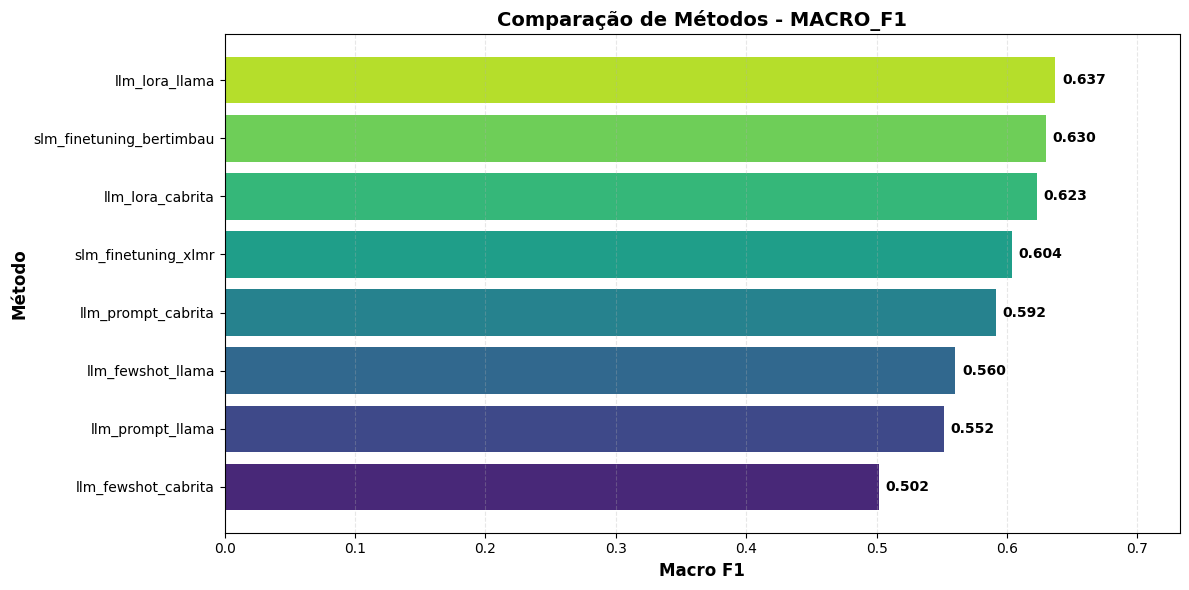


3. Gerando heatmap de métricas...
✅ Heatmap corrigido salvo em: ..\results\cross_dataset\metrics_heatmap.png


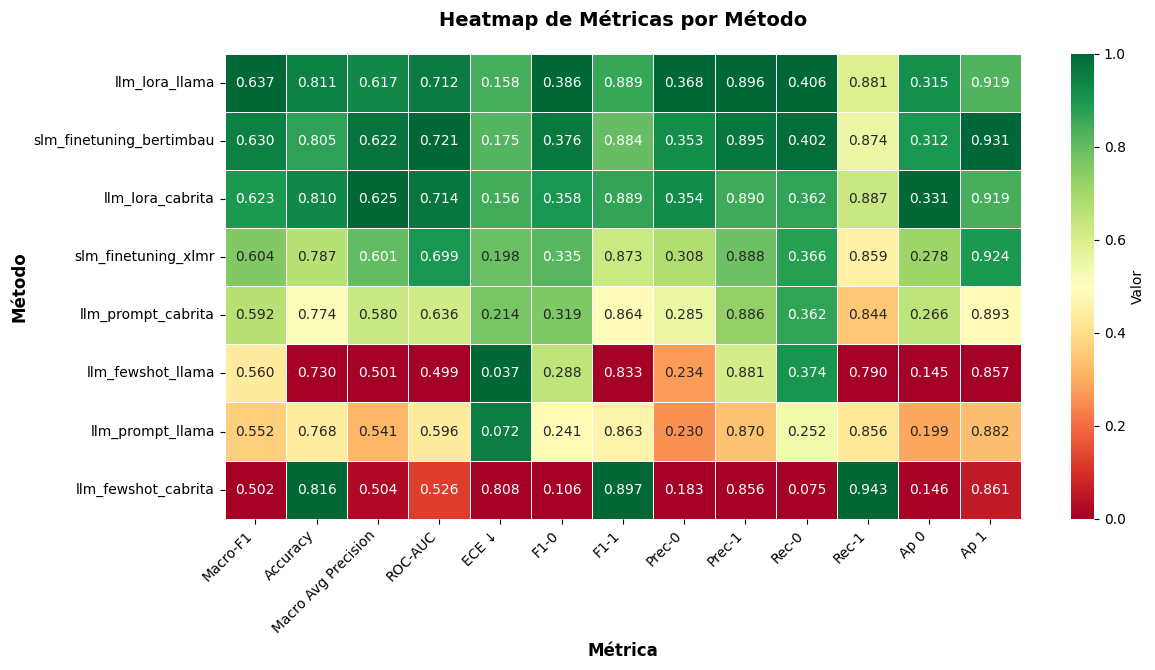


4. Gerando gráfico de performance por classe...
✅ Gráfico salvo em: ..\results\cross_dataset\class_performance.png


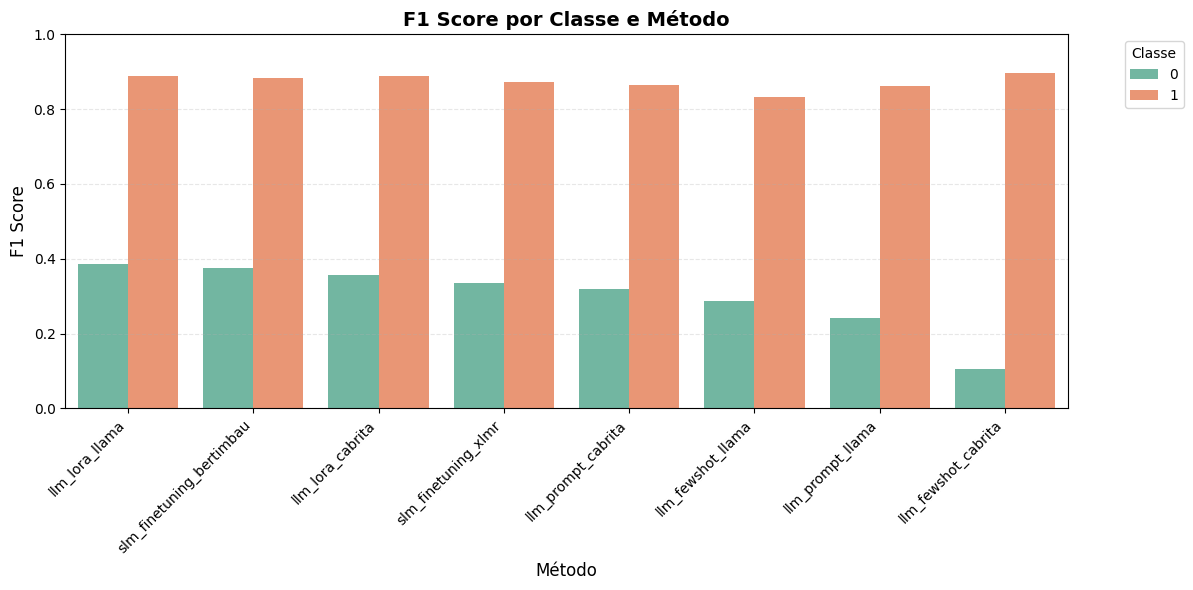


5. Gerando estatísticas...

ESTATÍSTICAS DESCRITIVAS

MACRO_F1:
  Melhor:  0.6371  (llm_lora_llama)
  Pior:    0.5018  (llm_fewshot_cabrita)
  Média:   0.5875
  Mediana: 0.5978
  Std:     0.0466

ACCURACY:
  Melhor:  0.8159  (llm_fewshot_cabrita)
  Pior:    0.7296  (llm_fewshot_llama)
  Média:   0.7875
  Mediana: 0.7960
  Std:     0.0296

ROC_AUC:
  Melhor:  0.7212  (slm_finetuning_bertimbau)
  Pior:    0.4991  (llm_fewshot_llama)
  Média:   0.6379
  Mediana: 0.6674
  Std:     0.0889

ECE:
  Melhor:  0.0373  (llm_fewshot_llama)
  Pior:    0.8084  (llm_fewshot_cabrita)
  Média:   0.2273
  Mediana: 0.1665
  Std:     0.2425


6. Gerando tabela Markdown...

❌ Erro ao gerar visualizações: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.
Verifique se o DataFrame 'df' ou 'df_results' existe

🎨 Funções disponíveis:
  - generate_latex_table(df)
  - plot_comparison(df, metric='macro_f1')
  - plot_metrics_heatmap(df)
  - plot_class_performance(df)
  - compare_method

In [4]:
"""
🎨 FUNÇÕES DE VISUALIZAÇÃO - VERSÃO CORRIGIDA
Execute DEPOIS do aggregate_results_simple.py
"""

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path

# ============================================================================
# FUNÇÃO 1: GERAR TABELA LATEX (CORRIGIDA)
# ============================================================================

def generate_latex_table(df, caption="Resultados dos Experimentos", label="tab:results"):
    """
    Gera tabela formatada para LaTeX
    
    Args:
        df: DataFrame com resultados
        caption: Legenda da tabela
        label: Label para referência
        
    Returns:
        String com código LaTeX
    """
    # Selecionar colunas principais
    main_metrics = ['experiment', 'macro_f1', 'accuracy']  # ← CORRIGIDO: underscore
    
    # Adicionar métricas avançadas se existirem
    if 'macro_ap' in df.columns:
        main_metrics.append('macro_ap')
    if 'roc_auc' in df.columns:
        main_metrics.append('roc_auc')
    if 'ece' in df.columns:
        main_metrics.append('ece')
    
    # Adicionar F1 por classe
    f1_cols = [col for col in df.columns if col.startswith('f1_') and col != 'macro_f1']
    main_metrics.extend(sorted(f1_cols))
    
    df_latex = df[main_metrics].copy()
    
    # Renomear colunas para LaTeX
    column_names = {
        'experiment': 'Método',
        'macro_f1': 'Macro-F1',
        'accuracy': 'Acurácia',
        'macro_ap': 'Macro-AP',
        'roc_auc': 'ROC-AUC',
        'ece': 'ECE',
    }
    
    # Renomear F1 por classe
    for col in f1_cols:
        class_name = col.replace('f1_', '').replace('_', ' ').title()
        column_names[col] = f'F1-{class_name}'
    
    df_latex = df_latex.rename(columns=column_names)
    
    # Formatar números (3 casas decimais)
    for col in df_latex.columns:
        if col != 'Método':
            df_latex[col] = df_latex[col].apply(lambda x: f"{x:.3f}" if pd.notna(x) else "---")
    
    # Destacar melhor valor em cada coluna (negrito)
    for col in df_latex.columns:
        if col != 'Método':
            # Mapear de volta para nome original
            original_col = None
            for orig, renamed in column_names.items():
                if renamed == col:
                    original_col = orig
                    break
            
            if original_col and original_col in df.columns:
                numeric_col = df[original_col]
                
                if col == 'ECE':  # Menor é melhor
                    best_idx = numeric_col.idxmin()
                else:  # Maior é melhor
                    best_idx = numeric_col.idxmax()
                
                current_value = df_latex.loc[best_idx, col]
                df_latex.loc[best_idx, col] = f"\\textbf{{{current_value}}}"
    
    # Gerar LaTeX
    latex_code = df_latex.to_latex(
        index=False,
        escape=False,
        caption=caption,
        label=label,
        position='htbp',
        column_format='l' + 'c' * (len(df_latex.columns) - 1)
    )
    
    return latex_code


# ============================================================================
# FUNÇÃO 2: PLOT COMPARAÇÃO (JÁ ESTAVA OK)
# ============================================================================

def plot_comparison(df, metric='macro_f1', figsize=(12, 6), save_path=None):
    """Plota comparação entre métodos"""
    
    if metric not in df.columns:
        print(f"⚠️  Métrica '{metric}' não encontrada no DataFrame")
        print(f"Métricas disponíveis: {df.columns.tolist()}")
        return
    
    plt.figure(figsize=figsize)
    
    # Ordenar por métrica
    df_plot = df.sort_values(metric, ascending=True)
    
    # Criar barplot
    colors = sns.color_palette("viridis", len(df_plot))
    bars = plt.barh(df_plot['experiment'], df_plot[metric], color=colors)
    
    # Adicionar valores nas barras
    for i, (bar, val) in enumerate(zip(bars, df_plot[metric])):
        plt.text(val + 0.005, i, f'{val:.3f}', va='center', fontsize=10, fontweight='bold')
    
    plt.xlabel(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    plt.ylabel('Método', fontsize=12, fontweight='bold')
    plt.title(f'Comparação de Métodos - {metric.upper()}', fontsize=14, fontweight='bold')
    plt.xlim(0, df_plot[metric].max() * 1.15)
    plt.grid(axis='x', alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Gráfico salvo em: {save_path}")
    
    plt.show()


# ============================================================================
# FUNÇÃO 3: PLOT METRICS HEATMAP (CORRIGIDA)
# ============================================================================

'''
def plot_metrics_heatmap(df, save_path=None):
    """Plota heatmap com todas as métricas"""
    
    # Selecionar apenas colunas numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if not numeric_cols:
        print("⚠️  Nenhuma métrica numérica encontrada")
        return
    
    # Criar matriz de dados
    data_matrix = df[numeric_cols].values
    
    # Normalizar por coluna (0-1) para melhor visualização
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    data_normalized = scaler.fit_transform(data_matrix)
    
    # Plot
    plt.figure(figsize=(max(12, len(numeric_cols) * 0.8), len(df) * 0.6 + 2))
    
    sns.heatmap(
        data_normalized,
        xticklabels=[col.replace('_', ' ').title() for col in numeric_cols],
        yticklabels=df['experiment'],
        annot=data_matrix,  # Mostrar valores originais
        fmt='.3f',
        cmap='RdYlGn',
        cbar_kws={'label': 'Valor Normalizado (0-1)'},
        linewidths=0.5
    )
    
    plt.title('Heatmap de Métricas por Método', fontsize=14, fontweight='bold')
    plt.xlabel('Métrica', fontsize=12)
    plt.ylabel('Método', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Heatmap salvo em: {save_path}")
    
    plt.show()
'''
"""
🔧 HEATMAP CORRIGIDO - Substitua a função plot_metrics_heatmap
Cole este código no lugar da função original
"""

def plot_metrics_heatmap(df, save_path=None):
    """
    Plota heatmap com todas as métricas
    CORRIGIDO: ECE invertido (menor é melhor)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler
    
    # Selecionar apenas colunas numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if not numeric_cols:
        print("⚠️  Nenhuma métrica numérica encontrada")
        return
    
    # Separar métricas onde MENOR é melhor
    minimize_metrics = ['ece']  # Adicione outras se houver
    
    # Criar cópia dos dados
    df_plot = df[['experiment'] + numeric_cols].copy()
    
    # INVERTER métricas onde menor é melhor (para normalização correta)
    for metric in minimize_metrics:
        if metric in df_plot.columns:
            # Inverter: transformar em "1 - valor" para que menor fique maior
            max_val = df_plot[metric].max()
            df_plot[metric] = max_val - df_plot[metric]
    
    # Criar matriz de dados (sem coluna 'experiment')
    data_matrix_original = df[numeric_cols].values  # Valores originais para anotação
    data_matrix = df_plot[numeric_cols].values      # Valores para normalização
    
    # Normalizar por coluna (0-1)
    scaler = MinMaxScaler()
    data_normalized = scaler.fit_transform(data_matrix)
    
    # Criar labels melhores para as métricas
    metric_labels = []
    for col in numeric_cols:
        # Substituir nomes genéricos
        label = col.replace('_', ' ').title()
        
        # Melhorar labels específicos
        label = label.replace('Macro F1', 'Macro-F1')
        label = label.replace('Macro Ap', 'Macro-AP')
        label = label.replace('Roc Auc', 'ROC-AUC')
        label = label.replace('Ece', 'ECE ↓')  # ↓ indica "menor é melhor"
        label = label.replace('F1 ', 'F1-')
        #label = label.replace('Ap 0', 'AP-NON-HATE')
        #label = label.replace('Ap 1', 'AP-HATE')
        label = label.replace('Precision ', 'Prec-')
        label = label.replace('Recall ', 'Rec-')
        
        metric_labels.append(label)
    
    # Plot
    fig_height = max(len(df) * 0.6 + 2, 6)
    fig_width = max(len(numeric_cols) * 0.8 + 2, 12)
    plt.figure(figsize=(fig_width, fig_height))
    
    # Criar heatmap
    ax = sns.heatmap(
        data_normalized,
        xticklabels=metric_labels,
        yticklabels=df['experiment'],
        annot=data_matrix_original,  # Mostrar valores ORIGINAIS
        fmt='.3f',
        cmap='RdYlGn',  # Vermelho = ruim, Verde = bom
        cbar_kws={'label': 'Valor'},
        linewidths=0.5,
        vmin=0,
        vmax=1,
        center=0.5
    )
    
    plt.title('Heatmap de Métricas por Método', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Métrica', fontsize=12, fontweight='bold')
    plt.ylabel('Método', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    
    # Adicionar nota sobre ECE
    '''
    if 'ece' in [c.lower() for c in numeric_cols]:
        plt.text(
            0.5, -0.15, 
            'Nota: ECE ↓ indica que valores menores são melhores (já invertido no heatmap)',
            ha='center', va='top', transform=ax.transAxes,
            fontsize=9, style='italic', color='gray'
        )
        '''
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Heatmap corrigido salvo em: {save_path}")
    
    plt.show()


# ============================================================================
# FUNÇÃO 4: PLOT CLASS PERFORMANCE (CORRIGIDA)
# ============================================================================

def plot_class_performance(df, save_path=None):
    """Plota performance por classe (F1 por classe)"""
    
    # Encontrar colunas F1 por classe
    f1_cols = [col for col in df.columns if col.startswith('f1_') and col != 'macro_f1']
    
    if not f1_cols:
        print("⚠️  Nenhuma métrica F1 por classe encontrada")
        return
    
    # Preparar dados para plot
    plot_data = df[['experiment'] + f1_cols].melt(
        id_vars='experiment',
        var_name='class',
        value_name='f1'
    )
    
    # Limpar nomes das classes
    plot_data['class'] = plot_data['class'].str.replace('f1_', '').str.replace('_', ' ').str.title()
    
    # Plot
    plt.figure(figsize=(max(12, len(df) * 1.5), 6))
    
    sns.barplot(
        data=plot_data,
        x='experiment',
        y='f1',
        hue='class',
        palette='Set2'
    )
    
    plt.title('F1 Score por Classe e Método', fontsize=14, fontweight='bold')
    plt.xlabel('Método', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Classe', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Gráfico salvo em: {save_path}")
    
    plt.show()


# ============================================================================
# FUNÇÃO 5: COMPARAR MÉTODOS (CORRIGIDA)
# ============================================================================

def compare_methods(df, method1, method2):
    """Compara dois métodos específicos"""
    
    # Verificar se métodos existem
    if method1 not in df['experiment'].values:
        print(f"⚠️  Método '{method1}' não encontrado")
        print(f"Métodos disponíveis: {df['experiment'].tolist()}")
        return
    
    if method2 not in df['experiment'].values:
        print(f"⚠️  Método '{method2}' não encontrado")
        print(f"Métodos disponíveis: {df['experiment'].tolist()}")
        return
    
    m1 = df[df['experiment'] == method1].iloc[0]
    m2 = df[df['experiment'] == method2].iloc[0]
    
    print(f"\n{'='*70}")
    print(f"COMPARAÇÃO: {method1} vs {method2}")
    print(f"{'='*70}\n")
    
    metrics = ['macro_f1', 'accuracy']
    if 'macro_ap' in df.columns:
        metrics.append('macro_ap')
    if 'roc_auc' in df.columns:
        metrics.append('roc_auc')
    if 'ece' in df.columns:
        metrics.append('ece')
    
    for metric in metrics:
        if metric in df.columns:
            v1 = m1[metric]
            v2 = m2[metric]
            diff = v1 - v2
            
            better = "✅" if diff > 0 else "❌"
            if metric == 'ece':  # Menor é melhor
                better = "✅" if diff < 0 else "❌"
            
            print(f"{metric:20s}: {v1:.4f} vs {v2:.4f}  {better} (Δ={diff:+.4f})")
    
    # F1 por classe
    f1_cols = [c for c in df.columns if c.startswith('f1_') and c != 'macro_f1']
    if f1_cols:
        print(f"\nF1 POR CLASSE:")
        for col in f1_cols:
            class_name = col.replace('f1_', '')
            v1 = m1[col]
            v2 = m2[col]
            diff = v1 - v2
            better = "✅" if diff > 0 else "❌"
            print(f"  {class_name:18s}: {v1:.4f} vs {v2:.4f}  {better} (Δ={diff:+.4f})")


# ============================================================================
# FUNÇÃO 6: ESTATÍSTICAS (CORRIGIDA)
# ============================================================================

def print_statistics(df):
    """Imprime estatísticas descritivas"""
    
    print(f"\n{'='*70}")
    print("ESTATÍSTICAS DESCRITIVAS")
    print(f"{'='*70}\n")
    
    metrics = ['macro_f1', 'accuracy']
    if 'macro_ap' in df.columns:
        metrics.append('macro_ap')
    if 'roc_auc' in df.columns:
        metrics.append('roc_auc')
    if 'ece' in df.columns:
        metrics.append('ece')
    
    for metric in metrics:
        if metric in df.columns:
            print(f"{metric.upper()}:")
            best_idx = df[metric].idxmax() if metric != 'ece' else df[metric].idxmin()
            worst_idx = df[metric].idxmin() if metric != 'ece' else df[metric].idxmax()
            
            print(f"  Melhor:  {df.loc[best_idx, metric]:.4f}  ({df.loc[best_idx, 'experiment']})")
            print(f"  Pior:    {df.loc[worst_idx, metric]:.4f}  ({df.loc[worst_idx, 'experiment']})")
            print(f"  Média:   {df[metric].mean():.4f}")
            print(f"  Mediana: {df[metric].median():.4f}")
            print(f"  Std:     {df[metric].std():.4f}")
            print()


# ============================================================================
# FUNÇÃO 7: EXPORT MARKDOWN (CORRIGIDA)
# ============================================================================

def to_markdown_table(df, save_path='results_table.md'):
    """Gera tabela formatada para Markdown"""
    
    cols = ['experiment', 'macro_f1', 'accuracy']
    if 'macro_ap' in df.columns:
        cols.append('macro_ap')
    if 'roc_auc' in df.columns:
        cols.append('roc_auc')
    if 'ece' in df.columns:
        cols.append('ece')
    
    df_md = df[cols].copy()
    
    # Formatar
    for col in cols:
        if col != 'experiment':
            df_md[col] = df_md[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "---")
    
    # Gerar markdown
    md_str = "# Resultados dos Experimentos\n\n"
    md_str += df_md.to_markdown(index=False)
    
    with open(save_path, 'w', encoding='utf-8') as f:
        f.write(md_str)
    
    print(f"✅ Tabela Markdown salva em: {save_path}")
    return md_str


# ============================================================================
# EXECUTAR (SE df_results EXISTIR)
# ============================================================================

if 'df' in locals() or 'df_results' in locals():
    # Usar df ou df_results (o que existir)
    df_to_use = df if 'df' in locals() else df_results
    
    print("\n" + "="*70)
    print("🎨 GERANDO VISUALIZAÇÕES E TABELAS")
    print("="*70)
    
    output_dir = Path(RESULTS_DIR) if 'RESULTS_DIR' in locals() else Path('./results/hatebr')
    
    try:
        # 1. Gerar tabela LaTeX
        print("\n1. Gerando tabela LaTeX...")
        latex_table = generate_latex_table(
            df_to_use,
            caption="Comparação de métodos PEFT para detecção de discurso de ódio",
            label="tab:peft_comparison"
        )
        
        # Salvar LaTeX
        latex_file = output_dir / "results_table.tex"
        with open(latex_file, 'w', encoding='utf-8') as f:
            f.write(latex_table)
        print(f"✅ Tabela LaTeX salva em: {latex_file}")
        
        # 2. Plot comparação Macro-F1
        print("\n2. Gerando gráfico de comparação (Macro-F1)...")
        plot_comparison(
            df_to_use,
            metric='macro_f1',
            save_path=output_dir / "comparison_f1.png"
        )
        
        # 3. Plot heatmap (se houver múltiplas métricas)
        numeric_cols = df_to_use.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 2:
            print("\n3. Gerando heatmap de métricas...")
            plot_metrics_heatmap(
                df_to_use,
                save_path=output_dir / "metrics_heatmap.png"
            )
        
        # 4. Plot performance por classe
        f1_cols = [col for col in df_to_use.columns if col.startswith('f1_') and col != 'macro_f1']
        if f1_cols:
            print("\n4. Gerando gráfico de performance por classe...")
            plot_class_performance(
                df_to_use,
                save_path=output_dir / "class_performance.png"
            )
        
        # 5. Estatísticas
        print("\n5. Gerando estatísticas...")
        print_statistics(df_to_use)
        
        # 6. Markdown
        print("\n6. Gerando tabela Markdown...")
        to_markdown_table(df_to_use, save_path=output_dir / "results_table.md")
        
        print("\n" + "="*70)
        print("✅ TODAS AS VISUALIZAÇÕES GERADAS!")
        print("="*70)
        print(f"\nArquivos salvos em: {output_dir}")
        print("  - results_table.tex")
        print("  - comparison_f1.png")
        print("  - metrics_heatmap.png (se aplicável)")
        print("  - class_performance.png")
        print("  - results_table.md")
        
    except Exception as e:
        print(f"\n❌ Erro ao gerar visualizações: {e}")
        print("Verifique se o DataFrame 'df' ou 'df_results' existe")

else:
    print("\n⚠️  Execute aggregate_results_simple.py primeiro para carregar os dados!")
    print("O DataFrame 'df' ou 'df_results' precisa existir antes.")

print("\n" + "="*70)
print("🎨 Funções disponíveis:")
print("  - generate_latex_table(df)")
print("  - plot_comparison(df, metric='macro_f1')")
print("  - plot_metrics_heatmap(df)")
print("  - plot_class_performance(df)")
print("  - compare_methods(df, 'metodo1', 'metodo2')")
print("  - print_statistics(df)")
print("  - to_markdown_table(df)")
print("="*70)

In [5]:
df_results

,experiment,macro_f1,accuracy,macro_avg_precision,roc_auc,ece,f1_0,f1_1,precision_0,precision_1,recall_0,recall_1,ap_0,ap_1
0,llm_lora_llama,0.637140,0.811277,0.616701,0.711728,0.158066,0.385768,0.888511,0.367857,0.896433,0.405512,0.880728,0.314894,0.918509
1,slm_finetuning_bertimbau,0.630055,0.804948,0.621973,0.721191,0.175027,0.375691,0.884419,0.352941,0.895100,0.401575,0.873989,0.312494,0.931453
2,llm_lora_cabrita,0.623283,0.810127,0.625112,0.714083,0.156228,0.357977,0.888589,0.353846,0.890392,0.362205,0.886792,0.330828,0.919396
3,slm_finetuning_xlmr,0.603910,0.787112,0.600742,0.698918,0.197524,0.334532,0.873288,0.307947,0.887883,0.366142,0.859164,0.277771,0.923712
4,llm_prompt_cabrita,0.591663,0.773878,0.579536,0.635949,0.213812,0.318891,0.864436,0.284830,0.885512,0.362205,0.844340,0.265980,0.893092
5,llm_fewshot_llama,0.560488,0.729574,0.501088,0.499083,0.037331,0.287879,0.833097,0.233990,0.880631,0.374016,0.790431,0.145323,0.856853
6,llm_prompt_llama,0.551687,0.767549,0.540560,0.596157,0.071742,0.240602,0.862772,0.230216,0.869863,0.251969,0.855795,0.199419,0.881701
7,llm_fewshot_cabrita,0.501758,0.815880,0.503584,0.526323,0.808400,0.106145,0.897370,0.182692,0.856181,0.074803,0.942722,0.146145,0.861023
